In [135]:
from py2neo import Graph
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


url = "neo4j+s://fa8d13fd.databases.neo4j.io"
user = "neo4j"
password = open("neo4j_passwd.secret").read().strip("\n")

In [136]:
graph = Graph(url, auth=(user, password))


In [137]:
query = f"""
MATCH (n:PR)
RETURN n.pr_id as id,n.created_at as create_time, n.merged_at as merge_time
"""
result = graph.run(query).to_data_frame()

In [138]:
# Convert columns to datetime
df = result.copy()
print(type(df['create_time'][0]))
df['create_time'] = df['create_time'].apply(lambda x: str(x))
df['merge_time'] = df['merge_time'].apply(lambda x: str(x))
df['create_time'] = pd.to_datetime(df['create_time'])
df['merge_time'] = pd.to_datetime(df['merge_time'])
# Calculate the time difference
df['hours_time_difference'] = (df['merge_time'] - df['create_time']).dt.total_seconds() / 3600

# Print the DataFrame
df.head()

<class 'interchange.time.DateTime'>


,id,create_time,merge_time,hours_time_difference
0,1850383999,2024-05-01 21:58:01+00:00,2024-05-09 00:23:16+00:00,170.420833
1,1858765927,2024-05-07 17:37:24+00:00,2024-05-08 12:45:24+00:00,19.133333
2,1860050710,2024-05-08 11:21:34+00:00,2024-05-08 11:33:40+00:00,0.201667
3,1854049855,2024-05-03 20:21:54+00:00,2024-05-07 20:52:22+00:00,96.507778
4,1854051479,2024-05-03 20:23:24+00:00,2024-05-07 19:52:00+00:00,95.476667


In [139]:
df.to_csv("pr_time.csv", index=False)

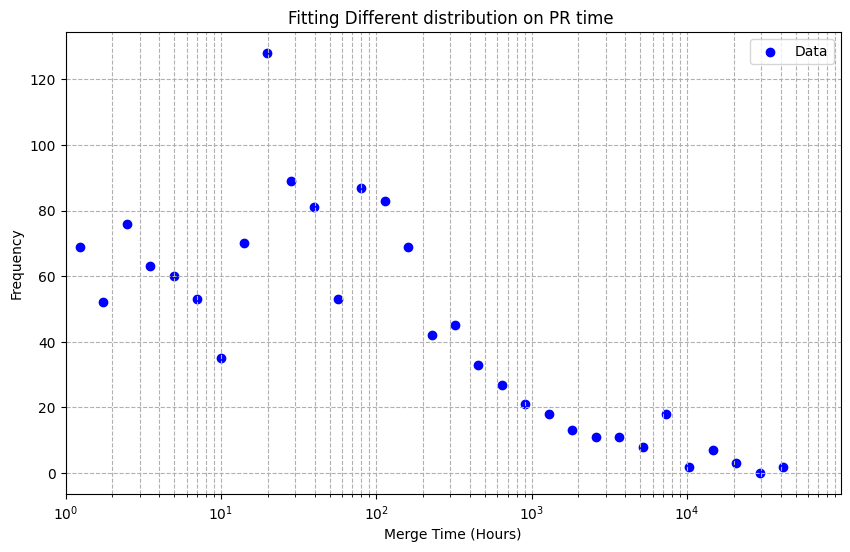

In [151]:
from scipy  import stats
num_bins = 50

# Calculate bin edges using logarithmic scale
min_value = df['hours_time_difference'].min()
max_value = df['hours_time_difference'].max()
bins = np.logspace(np.log10(min_value), np.log10(max_value), num_bins + 1)
#bins = np.linspace(min_value,max_value, num_bins + 1)

bin_centers = (bins[:-1] + bins[1:]) / 2
# Bin the data and calculate frequencies
hist, _ = np.histogram(df['hours_time_difference'], bins=bins)

shape_lognorm, loc_lognorm, scale_lognorm = stats.lognorm.fit(df['hours_time_difference'], floc=0)
shape_weibull, loc_weibull, scale_weibull = stats.weibull_min.fit(df['hours_time_difference'], floc=0)
x = np.linspace(df['hours_time_difference'].min(), df['hours_time_difference'].max(), 1000)

    
# Plot the histogram and fitted distributions
plt.figure(figsize=(10, 6))

# Weibull fit
x = np.linspace(df['hours_time_difference'].min(), df['hours_time_difference'].max(), 1000)
pdf_weibull = stats.weibull_min.pdf(x, shape_weibull, loc=loc_weibull, scale=scale_weibull)
#plt.plot(x, pdf_weibull, 'g-', lw=2, label='Weibull Fit')

pdf_lognorm = stats.lognorm.pdf(x, shape_lognorm, loc=loc_lognorm, scale=scale_lognorm)
#plt.plot(x, pdf_lognorm, 'r-', lw=2, label='Log-Normal Fit')
#plt.plot(x, pdf_weibull, 'g-', lw=2, label='Weibull Fit')

plt.scatter(bin_centers, hist, label='Data', color='blue')\
    
    
plt.xscale('log')
plt.xlim(1)
plt.yscale('linear')
plt.title('Fitting Different distribution on PR time ')
plt.xlabel('Merge Time (Hours)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

<class 'numpy.ndarray'>


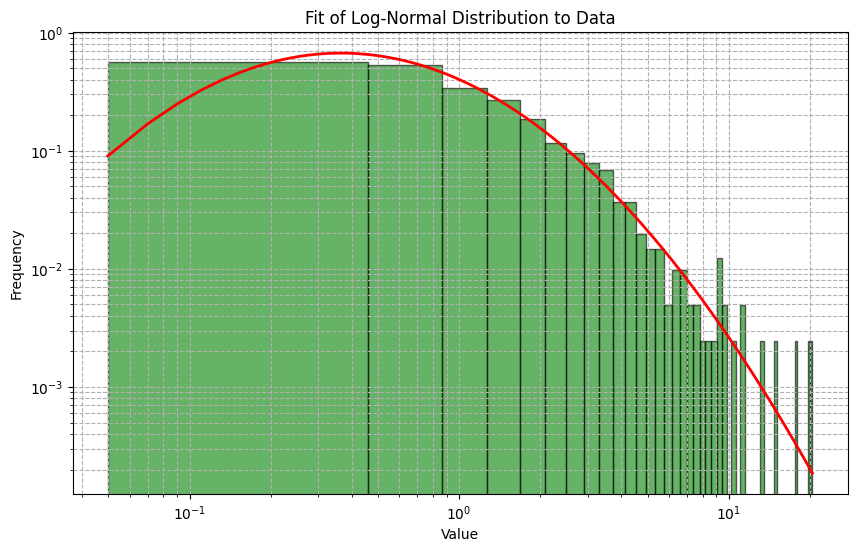

In [148]:
# Generate log-normal distributed data
mu, sigma = 0, 1  # mean and standard deviation of the underlying normal distribution
data = np.random.lognormal(mu, sigma, 1000)
print(type(data))
# Fit the data to a log-normal distribution
shape, loc, scale = stats.lognorm.fit(data, floc=0)

# Create a range of values for plotting the fitted distribution
x = np.linspace(min(data), max(data), 1000)
pdf_fitted = stats.lognorm.pdf(x, shape, loc=loc, scale=scale)

# Plot the histogram of the data
plt.figure(figsize=(10, 6))
plt.hist(data, bins=50, density=True, alpha=0.6, color='g', edgecolor='black')

# Plot the fitted log-normal distribution
plt.plot(x, pdf_fitted, 'r-', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.title('Fit of Log-Normal Distribution to Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--")
plt.show()


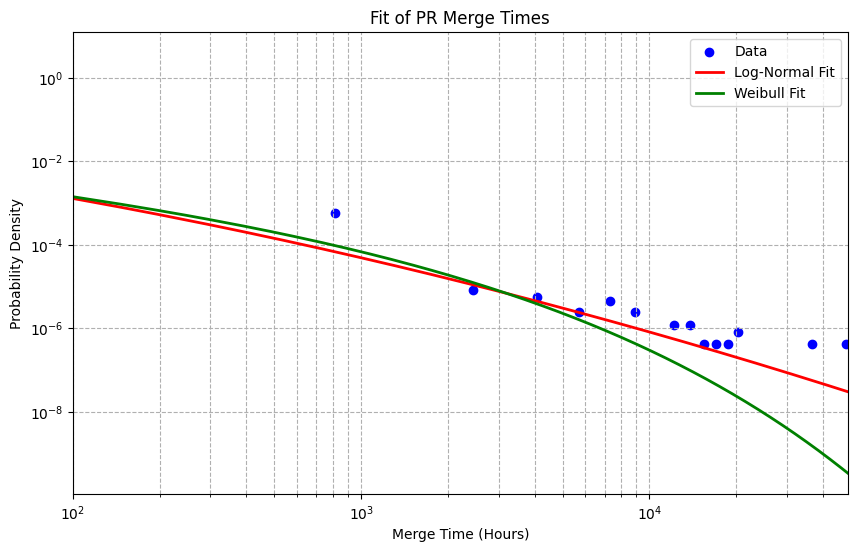

Log-Normal Parameters: shape=2.540291315627127, loc=0, scale=20.850153212788847
Weibull Parameters: shape=0.3909726748424188, loc=0, scale=74.76181391284697


In [142]:
import scipy.stats as stats
# Fit log-normal distribution
shape_lognorm, loc_lognorm, scale_lognorm = stats.lognorm.fit(df['hours_time_difference'], floc=0)

# Fit Weibull distribution
shape_weibull, loc_weibull, scale_weibull = stats.weibull_min.fit(df['hours_time_difference'], floc=0)

# Generate points for plotting
x = np.linspace(df['hours_time_difference'].min(), df['hours_time_difference'].max(), 1000)

# Plot the histogram and fits
plt.figure(figsize=(10, 6))

# Empirical data histogram
hist, bins = np.histogram(df['hours_time_difference'], bins=30, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.scatter(bin_centers, hist, label='Data', color='blue')

# Log-normal fit
pdf_lognorm = stats.lognorm.pdf(x, shape_lognorm, loc=loc_lognorm, scale=scale_lognorm)
plt.plot(x, pdf_lognorm, 'r-', lw=2, label='Log-Normal Fit')

# Weibull fit
pdf_weibull = stats.weibull_min.pdf(x, shape_weibull, loc=loc_weibull, scale=scale_weibull)
plt.plot(x, pdf_weibull, 'g-', lw=2, label='Weibull Fit')

# Log-log scale
plt.xscale('log')
plt.yscale('log')

plt.title('Fit of PR Merge Times')
plt.xlabel('Merge Time (Hours)')
plt.ylabel('Probability Density')
plt.xlim(100, df['hours_time_difference'].max())
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

# Print the parameters
print(f'Log-Normal Parameters: shape={shape_lognorm}, loc={loc_lognorm}, scale={scale_lognorm}')
print(f'Weibull Parameters: shape={shape_weibull}, loc={loc_weibull}, scale={scale_weibull}')